# Extract network statistics

Loop over networks and extract various network statistics.

# Setup
## Packages

In [1]:
# Import packages
import numpy as np
import scipy as sp
import networkx as nx
import decimal
import math
import pandas as pd
import statsmodels.api as sm
import datetime
import pickle

# To import Matlab matrices
import scipy.io

# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

In [2]:
# Suppress the warnings from matplotlib about networkx
import warnings
warnings.filterwarnings("ignore")
# Pandas display settings
pd.set_option("display.max_rows",999)
pd.options.display.float_format = '{:,.2f}'.format
#Seaborn display settings
sns.set(style="ticks", palette="Greys", font_scale=1.4)
#Display plots inside notebook
%matplotlib inline

In [3]:
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2020-05-07 17:47:27'

## Functions

I created several functions to import the network data and produce a pandas dataframe of network measures.

In [4]:
from fbr_functions import *

Notes:
- When you call `to_numpy_matrix` you must specify `weight=None`. Otherwise, you will get lots of zeroes in the adjacency matrix. 
- For consistency, it's important that the statistics are extracted the same network. For example, if average distance must be calculated on the giant component, then all other network statistics should also be calculated on the giant component.

# Data

## Test Networks

In [5]:
def testNetworks(n):
    '''
    Test the methods on small well-known networks
    with n nodes (except the triangular lattice
    which is defined by rows and columns of 
    triangles).
    
    Return: dict of networkx graphs
    '''
    return {"star":nx.star_graph(n-1) ,
            "cycle":nx.cycle_graph(n), 
            "complete":nx.complete_graph(n),
            "wheel":nx.wheel_graph(n),
            "triangular lattice":nx.triangular_lattice_graph(3,3)}
            

In [6]:
NS0 = NetStats()
test_data = NS0.collect(testNetworks(14))
test_data

,ave_dist,ave_clust,num_edges,ave_deg,diameter,density,num_nodes,info_total,info_total_friend_only,info_expostIC,info_SP,links_supported,comp_total,comp_supp,comp_trans,comp_by_three,key
0,1.86,0.00,13,1.86,2,0.14,14,1.00,0.86,0.00,0.86,0.00,0.86,0.00,0.00,0.00,star
1,3.77,0.00,14,2.00,7,0.15,14,0.31,0.15,0.00,0.12,0.00,0.15,0.00,0.00,0.00,cycle
2,1.00,1.00,91,13.00,1,1.00,14,1.00,1.00,1.00,0.86,1.00,1.00,1.00,0.00,0.00,complete
3,1.71,0.63,26,3.71,2,0.29,14,1.00,1.00,1.00,0.86,1.00,1.00,0.29,0.71,0.00,wheel
4,1.78,0.64,18,3.60,3,0.40,10,0.82,0.82,0.82,0.47,1.00,0.82,0.40,0.42,0.00,triangular lattice


## India Networks

The networks need to be downloaded from the source and saved in the folder `/Data/BCDJ_Science/`. Each network is a .csv file.

Source:
- [The Diffusion of Microfinance Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/21538)

Citation:
- Banerjee, Abhijit, Arun G. Chandrasekhar, Esther Duflo, and Matthew O. Jackson. 2013. "The diffusion of microfinance." Science 341, no. 6144

In [7]:
def IndiaNetworks():
    '''
    75 villages from Karnataka India, sourced from Banerjee, Chandrasekhar, Duflo and Jackson 2014 Science.
    
    Comment: Most (possibly all) of the networks contain isolated nodes.
    
    Return: dict of networkx graphs
    '''
    result = {}
    for i in range(1,78):
        if i == 13 or i == 22:
            continue # Two villages were excluded from the final data
        input_data = np.loadtxt('../Data/BCDJ_Science/adj_allVillageRelationships_HH_vilno_'+str(i)+'.csv', delimiter=',', dtype=int)
        result[i] = nx.from_numpy_matrix(input_data)
    return result

In [8]:
g_India = IndiaNetworks()

In [9]:
NS1 = NetStats()
network_data_India = NS1.collect(g_India, extract_from_giant=False)
network_data_India.describe()

,ave_dist,ave_clust,num_edges,ave_deg,diameter,density,num_nodes,info_total,info_total_friend_only,info_expostIC,info_SP,links_supported,comp_total,comp_supp,comp_trans,comp_by_three,key
count,0.00,75.00,75.00,75.00,0.00,75.00,75.00,75.00,75.00,75.00,0.00,75.00,75.00,75.00,75.00,75.00,75.00
mean,nan,0.25,891.49,8.90,nan,0.05,198.72,0.35,0.34,0.24,nan,0.82,0.34,0.04,0.20,0.00,39.57
std,nan,0.05,338.93,1.63,nan,0.02,60.09,0.10,0.10,0.10,nan,0.06,0.10,0.02,0.08,0.00,22.38
min,nan,0.15,334.00,6.11,nan,0.02,77.00,0.17,0.17,0.09,nan,0.68,0.17,0.02,0.07,0.00,1.00
25%,nan,0.21,613.50,7.79,nan,0.04,155.50,0.26,0.25,0.16,nan,0.78,0.25,0.03,0.13,0.00,20.50
50%,nan,0.24,868.00,8.72,nan,0.05,190.00,0.33,0.32,0.23,nan,0.82,0.32,0.04,0.19,0.00,40.00
75%,nan,0.29,"1,077.00",9.72,nan,0.06,241.00,0.41,0.40,0.31,nan,0.86,0.40,0.05,0.26,0.00,58.50
max,nan,0.44,"2,015.00",13.44,nan,0.11,356.00,0.60,0.59,0.54,nan,0.95,0.59,0.11,0.43,0.00,77.00


In [10]:
NS1_g = NetStats()
network_data_India_giant = NS1_g.collect(g_India, extract_from_giant=True)

## Indonesia Networks

The networks need to be downloaded from the source and saved in the folder `/Data/ABCHO_AER/`. The networks are saved as Matlab matrices within the Matlab file `finalData.mat`.


Source:
- Attached to [Alatas et al (2016) American Economic Review](https://www.aeaweb.org/articles?id=10.1257/aer.20140705)

Citation:
- Alatas, Vivi, Abhijit Banerjee, Arun G. Chandrasekhar, Rema Hanna, and Benjamin A. Olken. 2016. "Network Structure and the Aggregation of Information: Theory and Evidence from Indonesia." American Economic Review, 106 (7): 1663-1704. DOI: 10.1257/aer.20140705

In [11]:
# def IndonesiaData():
#     '''
# #     Over 600 villages in Indonesia from Alatas Banerjee Chandrasekhar Hanna and Olken 2016 AER
    
# #     Return a dictionary of networks.
#     '''
#     result = {}
#     for i in range(1,634):
#         input_data = np.loadtxt('../Data/ABCHO_AER/' + str(i)+'.csv', delimiter=',', dtype=int)
#         result[i] = nx.from_numpy_matrix(input_data)
#    return result

# Extract directly from Matlab files

def IndonesiaData():
    '''
    Over 600 villages in Indonesia from Alatas Banerjee Chandrasekhar Hanna and Olken 2016 AER
    
    Return a dictionary of networks.
    '''
    result = {}
    dataset_matlab = scipy.io.loadmat('../Data/ABCHO_AER/finalData')
    for i in range(0,633):
        village = str(dataset_matlab['finalData']['index'][0][0][0][i])
        graph = nx.from_numpy_matrix(dataset_matlab['finalData']['graph'][i][0])
        hhid = [item for sublist in dataset_matlab['finalData']['key'][i][0].tolist() for item in sublist]
        mapping = dict(zip(graph, hhid))
        graph = nx.relabel_nodes(graph, mapping)
        result[village] = graph
    return result

In [12]:
g_Indo = IndonesiaData()

In [13]:
NS2 = NetStats()
network_data_Indonesia = NS2.collect(g_Indo, extract_from_giant=False)
network_data_Indonesia.describe()

,ave_dist,ave_clust,num_edges,ave_deg,diameter,density,num_nodes,info_total,info_total_friend_only,info_expostIC,info_SP,links_supported,comp_total,comp_supp,comp_trans,comp_by_three
count,5.00,633.00,633.00,633.00,5.00,633.00,633.00,633.00,633.00,633.00,0.00,633.00,633.00,633.00,633.00,633.00
mean,1.50,0.41,89.84,3.85,3.00,0.10,52.99,0.22,0.22,0.20,nan,0.93,0.22,0.10,0.10,0.00
std,0.34,0.18,65.84,2.65,0.71,0.11,27.33,0.20,0.20,0.19,nan,0.10,0.20,0.11,0.10,0.00
min,1.14,0.00,1.00,0.08,2.00,0.00,11.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,0.00
25%,1.27,0.28,44.00,1.81,3.00,0.03,35.00,0.07,0.06,0.05,nan,0.92,0.06,0.03,0.02,0.00
50%,1.38,0.42,75.00,3.22,3.00,0.07,48.00,0.16,0.16,0.14,nan,0.96,0.16,0.07,0.07,0.00
75%,1.79,0.54,116.00,5.32,3.00,0.13,64.00,0.32,0.32,0.30,nan,0.98,0.32,0.13,0.16,0.00
max,1.93,0.93,573.00,15.86,4.00,0.86,263.00,1.00,1.00,1.00,nan,1.00,1.00,0.86,0.49,0.00


Note that the average degree does not match the average degree reported in Alatas et al (2016) due to a minor coding error in their Table 1. 

They use the mean of ``degree_Random`` which the mean of the average degree for the 8 randomly selected households in each village rather than average degree for every node in the village. The code should have taken the mean of ``avg_degree``. 


See ``do/Main Tables/VillageLevelReg.do`` in the Alatas et al (2016) replication files.

In [14]:
NS2_g = NetStats()
network_data_Indonesia_giant = NS2_g.collect(IndonesiaData(), extract_from_giant=True)

In [15]:
network_data_Indonesia_giant.describe()

,ave_dist,ave_clust,num_edges,ave_deg,diameter,density,num_nodes,info_total,info_total_friend_only,info_expostIC,info_SP,links_supported,comp_total,comp_supp,comp_trans,comp_by_three
count,633.00,633.00,633.00,633.00,633.00,633.00,633.00,633.00,633.00,633.00,296.00,633.00,633.00,633.00,633.00,633.00
mean,2.04,0.73,84.00,6.50,4.17,0.36,23.60,0.71,0.70,0.63,0.53,0.95,0.70,0.34,0.28,0.00
std,0.51,0.12,66.46,2.51,1.49,0.19,12.33,0.18,0.19,0.20,0.16,0.08,0.19,0.19,0.12,0.00
min,1.00,0.00,1.00,1.00,1.00,0.09,2.00,0.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.70,0.67,38.00,4.96,3.00,0.23,15.00,0.59,0.57,0.49,0.44,0.94,0.57,0.21,0.22,0.00
50%,2.03,0.74,66.00,6.15,4.00,0.30,22.00,0.71,0.69,0.62,0.51,0.97,0.69,0.29,0.30,0.00
75%,2.33,0.80,109.00,7.72,5.00,0.43,31.00,0.87,0.85,0.75,0.65,0.99,0.85,0.42,0.37,0.00
max,4.81,1.00,562.00,20.67,12.00,1.00,82.00,1.00,1.00,1.00,0.89,1.00,1.00,1.00,0.55,0.00


In [16]:
# Note length of time taken to reach this stage
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2020-05-08 11:07:01'

## Merge into a single dataframe
It s easier to plot with seaborn if I create a single dataframe with both countries.

In [17]:
network_data_India['country'] = 'India'
network_data_Indonesia['country'] = 'Indonesia'
network_data_India['calculated_on'] = 'full'
network_data_Indonesia['calculated_on'] = 'full'

network_data_India_giant['country'] = 'India'
network_data_Indonesia_giant['country'] = 'Indonesia'
network_data_India_giant['calculated_on'] = 'giant'
network_data_Indonesia_giant['calculated_on'] = 'giant'

df = pd.concat([network_data_India,network_data_Indonesia,network_data_India_giant,network_data_Indonesia_giant])

## Save data
Save the panda dataframes to pickle files so that I don't need to extract the data again.

In [18]:
df.to_pickle('pd_df/netdata.pickle')

Also save to csv.

In [19]:
df.to_csv('pd_df/netdata.csv')

# Networks

In [20]:
g = NS2_g.networks['125']['g']

Example networks, shown with the optimal partition for the bipartite mechanism.

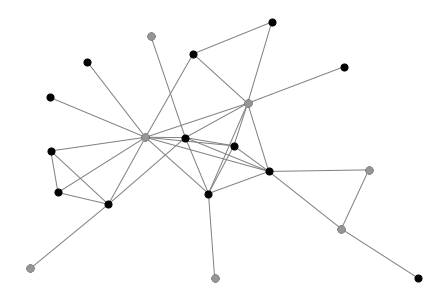

In [21]:
nx.draw(g, 
        pos=nx.kamada_kawai_layout(g), 
        node_size=50, 
        node_color="black",
        edge_color="grey")
nx.draw_networkx_nodes(g,nx.kamada_kawai_layout(g), 
                       nodelist=NS2_g.networks['125']['g_bi']['max_bi_info_nodes'], node_color='#969696',node_size=50)

Save the networks to pickle files.

In [24]:
pickle.dump(NS1,open( "pd_df/india_networks.pickle", "wb" ))

In [25]:
pickle.dump(NS2_g,open( "pd_df/india_networks_giant.pickle", "wb" ))

In [26]:
pickle.dump(NS2,open( "pd_df/indo_networks.pickle", "wb" ))

In [27]:
pickle.dump(NS2_g,open( "pd_df/indo_networks_giant.pickle", "wb" ))